# Application: using Piven on yearpredictionMSD dataset

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from piven.models import PivenMlpModel
import tensorflow as tf
from sklearn.compose import TransformedTargetRegressor

dpath = Path("data/YearPredictionMSD.txt")

In [2]:
records = []
with dpath.open("r") as infile:
    for line in infile.readlines():
        line_split = line.replace("\n", "").split(",")
        year = int(line_split[0])
        inputs = [*map(lambda x: float(x), line_split[1:])]
        records.append([year] + inputs)

In [3]:
df = pd.DataFrame(records)

In [4]:
df.columns = ["year"] + [f"feature_{i}" for i in range(1, df.shape[-1])]

In [5]:
df.head()

,year,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [6]:
df.shape

(515345, 91)

In [8]:
# Split as per instructions https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD
train_samples = 463715
train = df.iloc[:train_samples,:]
test = df.iloc[train_samples:, :]

train_y = train.year.values
test_y = test.year.values
train_x = train.iloc[:, 1:].values
test_x = test.iloc[:, 1:].values

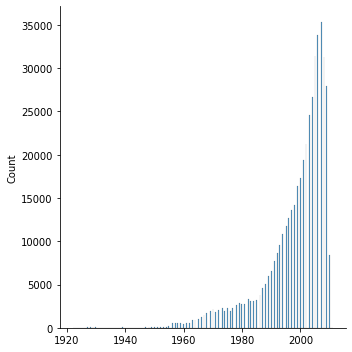

In [9]:
sns.displot(train_y)
plt.show()

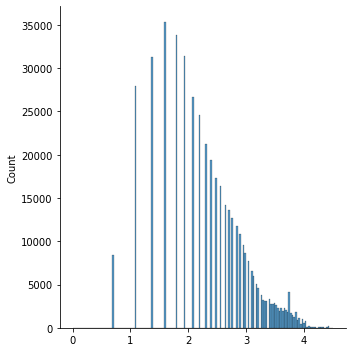

In [10]:
# Transform outcome variable (left-skewed)

max_out_train = np.max(train_y)

def reflect_and_log(x, max_out_train):
    return np.log(1 + max_out_train - train_y)

train_y_transformed = reflect_and_log(train_y, max_out_train)
test_y_transformed = reflect_and_log(test_y, max_out_train)

sns.displot(train_y_transformed)
plt.show()

In [20]:
from sklearn.preprocessing import StandardScaler
model_ttr = PivenMlpModel(
    input_dim = train_x.shape[-1],
    dense_units=(16, 16),
    dropout_rate=(0.1, 0.1,),
    lambda_=22.0,
    bias_init_low=-3.0,
    bias_init_high=3.0,
    lr=0.000428,
)
model_ttr.build_model(preprocess=StandardScaler())

PivenTransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                           StandardScaler()),
                                                          ('model',
                                                           <piven.scikit_learn.wrappers.PivenKerasRegressor object at 0x7fd639a12850>)]),
                                transformer=StandardScaler())

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001
)

# Fit
h = model_ttr.fit(train_x, train_y_transformed, model__epochs=25, 
                  model__validation_split=0.2, model__batch_size=64,
                  model__callbacks=[early_stop, reduce_lr])

Epoch 1/25
5797/5797 [==============================] - 6s 968us/step - loss: 5.5875 - picp: 0.9394 - mpiw: 4.2488 - val_loss: 5.3433 - val_picp: 0.9404 - val_mpiw: 3.6158
Epoch 2/25
5797/5797 [==============================] - 5s 919us/step - loss: 4.7059 - picp: 0.9338 - mpiw: 3.5706 - val_loss: 4.9854 - val_picp: 0.9377 - val_mpiw: 3.3341
Epoch 3/25
5797/5797 [==============================] - 5s 923us/step - loss: 4.3943 - picp: 0.9339 - mpiw: 3.3565 - val_loss: 4.8269 - val_picp: 0.9364 - val_mpiw: 3.2021
Epoch 4/25
5797/5797 [==============================] - 5s 917us/step - loss: 4.2322 - picp: 0.9315 - mpiw: 3.2157 - val_loss: 4.7538 - val_picp: 0.9379 - val_mpiw: 3.1364
Epoch 5/25
5797/5797 [==============================] - 5s 928us/step - loss: 4.1108 - picp: 0.9331 - mpiw: 3.1471 - val_loss: 4.6336 - val_picp: 0.9421 - val_mpiw: 3.1312
Epoch 6/25
5797/5797 [==============================] - 5s 928us/step - loss: 4.0499 - picp: 0.9324 - mpiw: 3.0903 - val_loss: 4.5062 - val_

In [22]:
ypred, y_pi_low, y_pi_high = model_ttr.predict(test_x, return_prediction_intervals=True)

In [23]:
# Back-transform the predictions and PIs
def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp
ypred = back_transform(ypred, max_out_train)
# Need to reverse the bounds
y_pi_low_t = back_transform(y_pi_high, max_out_train)
y_pi_high_t = back_transform(y_pi_low, max_out_train)

In [24]:
model_ttr.score(test_y, ypred, y_pi_low_t, y_pi_high_t)

{'loss': 119.2404946753735,
 'mae': 6.139643905081075,
 'rmse': 9.50756875186126,
 'coverage': 0.9358899864419911,
 'pi_width': 27.658212661743164}

In [26]:
col_out = (y_pi_low_t <= test_y) & (test_y <= y_pi_high_t)
colmap = np.array(["green" if cov else "red" for cov in col_out])

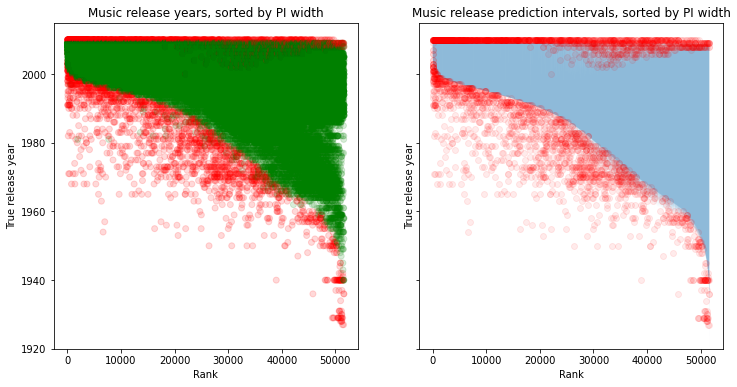

In [27]:
pi_width_sorted_idx = np.argsort(y_pi_high_t - y_pi_low_t)
test_y_sorted = test_y[pi_width_sorted_idx]
colmap_sorted = colmap[pi_width_sorted_idx]

fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)
ax[0].scatter(range(test_y.shape[0]), test_y_sorted, c=colmap_sorted,alpha=0.15)
ax[0].set_ylim(1920, 2015)
ax[0].set_title("Music release years, sorted by PI width")
ax[0].set_xlabel("Rank")
ax[0].set_ylabel("True release year")

pred_wrong = test_y_sorted[colmap_sorted == "red"]
year_wrong = np.array([*range(test_y.shape[0])])[colmap_sorted == "red"]
ax[1].fill_between(
    range(test_y.shape[0]),
    y_pi_low_t[pi_width_sorted_idx],
    y_pi_high_t[pi_width_sorted_idx],
    alpha=0.5
)
ax[1].scatter(year_wrong, pred_wrong, c="r", alpha=0.08)
ax[1].set_ylim(1920, 2015)
ax[1].set_title("Music release prediction intervals, sorted by PI width")
ax[1].set_xlabel("Rank")
ax[1].set_ylabel("True release year")

plt.show()

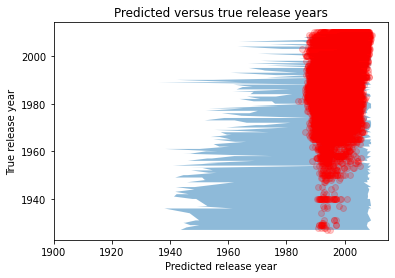

In [29]:
idx_sort = np.argsort(test_y)
plt.fill_betweenx(
    test_y[idx_sort],
    y_pi_low_t[idx_sort],
    y_pi_high_t[idx_sort],
    alpha=0.5
)
plt.scatter(ypred[idx_sort], test_y[idx_sort], c="r", alpha=0.2)
plt.xlim(1900, 2015)
plt.title("Predicted versus true release years")
plt.xlabel("Predicted release year")
plt.ylabel("True release year")
plt.show()

The PI are getting smaller as the true release year gets closer to 2012. This makes sense as the bulk of the data is there.